In [1]:
rm(list = ls())
gc(reset = TRUE)

if(Sys.getenv('USERNAME') == 'UOS') setwd('C:\\Users\\UOS\\Desktop\\dacon')
if(Sys.getenv('USERNAME') == 'moon') setwd('D:\\Project\\git\\Predict-KBO-OPS\\src')
if(Sys.getenv('USERNAME') == 'kyucheol') setwd('C:\\Users\\kyucheol\\Dropbox\\dacon')

if(!require(tidyverse)) install.packages('tidyverse'); require(tidyverse)
if(!require(data.table)) install.packages('data.table'); require(data.table)
if(!require(corrplot)) install.packages('corrplot'); require(corrplot)

options(warn = -1, tibble.width = Inf)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,510734,27.3,1097818,58.7,510734,27.3
Vcells,978541,7.5,8388608,64.0,978541,7.5


Loading required package: tidyverse
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
√ ggplot2 3.1.0       √ purrr   0.3.1  
√ tibble  2.0.1       √ dplyr   0.8.0.1
√ tidyr   0.8.3       √ stringr 1.4.0  
√ readr   1.3.1       √ forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: data.table

Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'package:purrr':

    transpose

Loading required package: corrplot
corrplot 0.84 loaded


In [23]:
rsb_tmp = fread('data/Regular_Season_Batter.csv', encoding = 'UTF-8') %>% as.tibble

rsb <- rsb_tmp %>% select(batter_id:year,avg:GDP)

colnames(rsb) <- c(colnames(rsb)[1:8], 'TWB', 'THB', colnames(rsb)[11:length(rsb)])

### 변수들의 density plot

```r

density_plot <- function(){
  for(i in 1:16){
    print(ggplot(data = rsb, aes_string(colnames(rsb)[i+3])) + geom_density(stat = 'density') + xlab(colnames(rsb)[i+3]))
  }
}

density_plot()

```

### log scale 해서 plot을 그리기, 결과적으로 정규분포의 꼴을 만들기는 어려움.

```r
skew_col <- colnames(rsb)[7:19]

log_density_plot <- function(){
  for(i in 1:13){
    print(ggplot(data = rsb, aes_string(skew_col[i])) + geom_density(stat = 'density') + xlab(skew_col[i]) + scale_x_continuous(trans='log10'))
  }
}

log_density_plot()

```

### G, AB가 높을 경우, 당연하게 안타를 많이 침

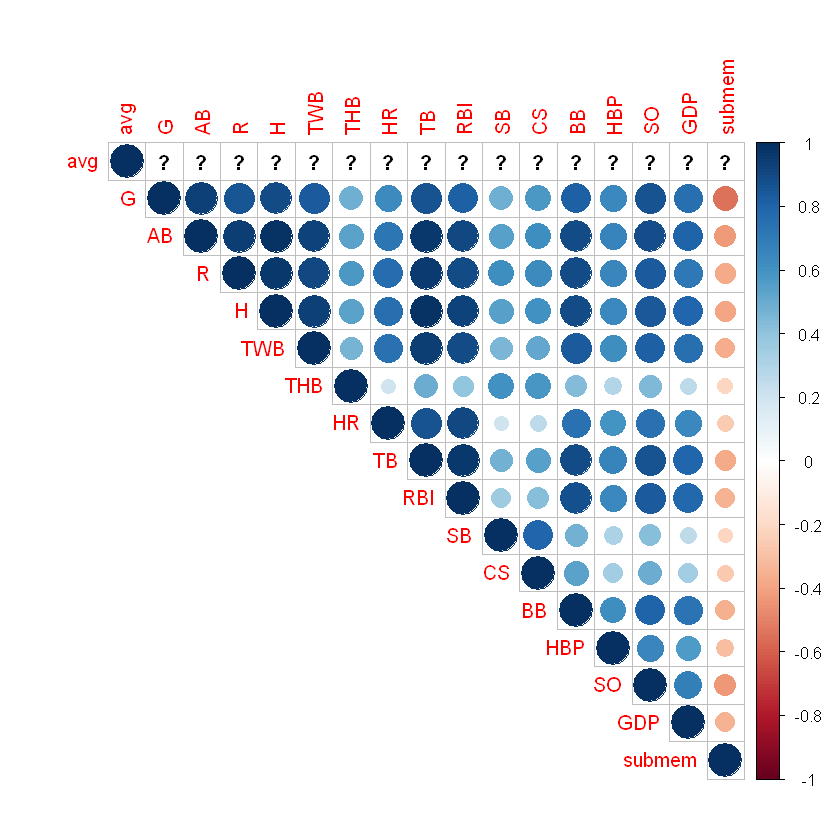

In [6]:
rsb2 <- rsb %>% mutate(submem = if_else(AB < 10, 1, 0))

cm <- cor(rsb2[,4:20])

corrplot(cm, method = 'circle', type = 'upper')

### Case1. 1 ~ 3루타, 홈런의 비율을 사용

In [14]:
colnames(rsb)

[1] "batter_id"   "batter_name" "year"        "avg"         "G"          
 [6] "AB"          "R"           "H"           "TWB"         "THB"        
[11] "HR"          "TB"          "RBI"         "SB"          "CS"         
[16] "BB"          "HBP"         "SO"          "GDP"

In [24]:
rsb <- rsb %>% mutate(ONB = H - TWB - THB - HR) %>% select(batter_id:H, ONB, TWB:GDP, -TB)

In [19]:
colnames(rsb)

[1] "batter_id"   "batter_name" "year"        "avg"         "G"          
 [6] "AB"          "R"           "H"           "ONB"         "TWB"        
[11] "THB"         "HR"          "RBI"         "SB"          "CS"         
[16] "BB"          "HBP"         "SO"          "GDP"

In [25]:
rsb_r <- rsb %>% mutate_at(vars('ONB':'HR'), funs(R = ./H))

In [27]:
rsb_r <- rsb_r %>% mutate(submem = if_else(AB < 10, 1, 0))

In [34]:
new_col <- c('ONB_R', 'TWB_R', 'THB_R', 'HR_R')

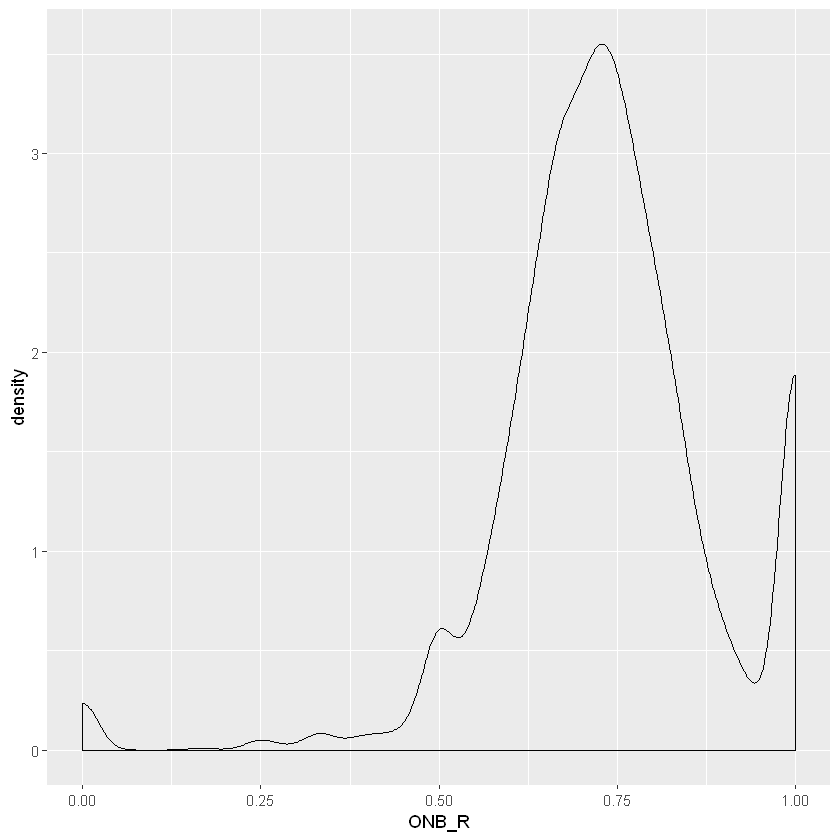

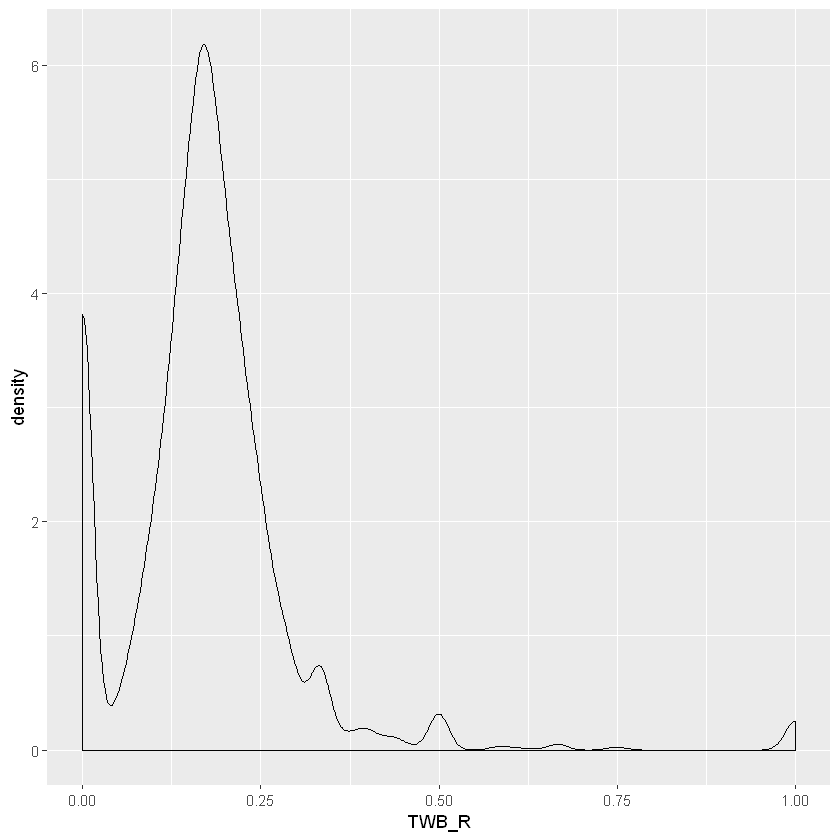

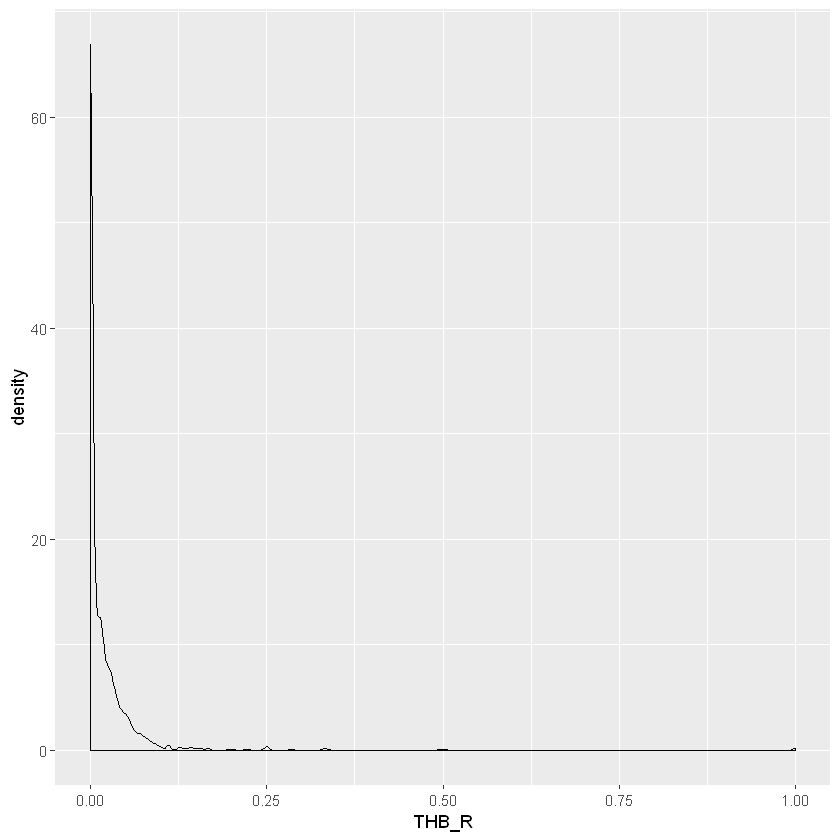

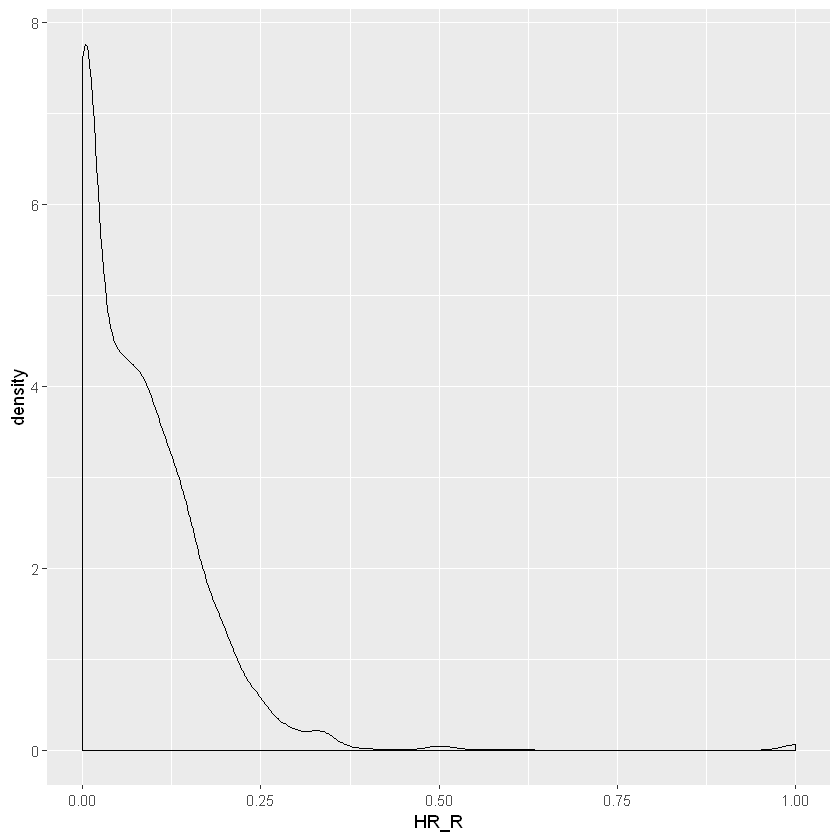

In [35]:
density_plot <- function(){
  for(i in new_col){
    print(ggplot(data = rsb_r, aes_string(i)) + geom_density(stat = 'density') + xlab(i))
  }
}

density_plot()

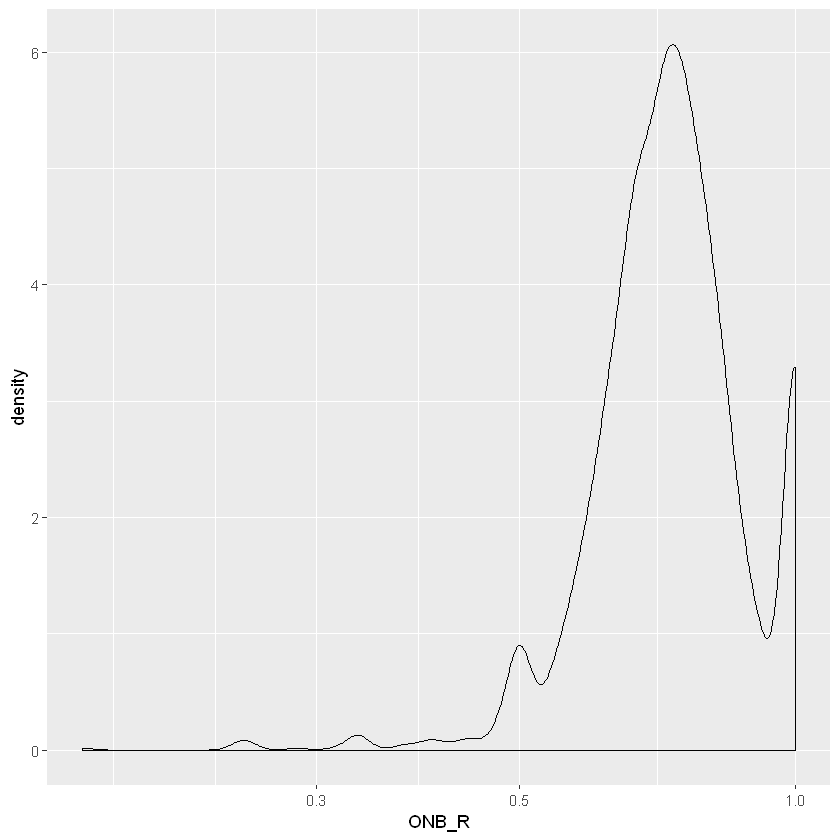

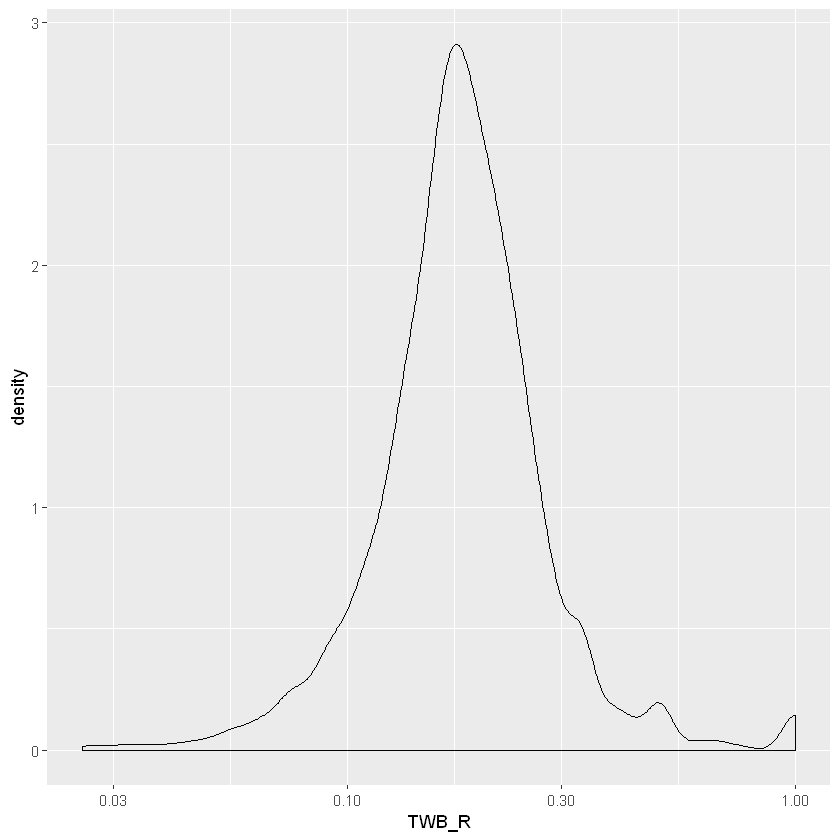

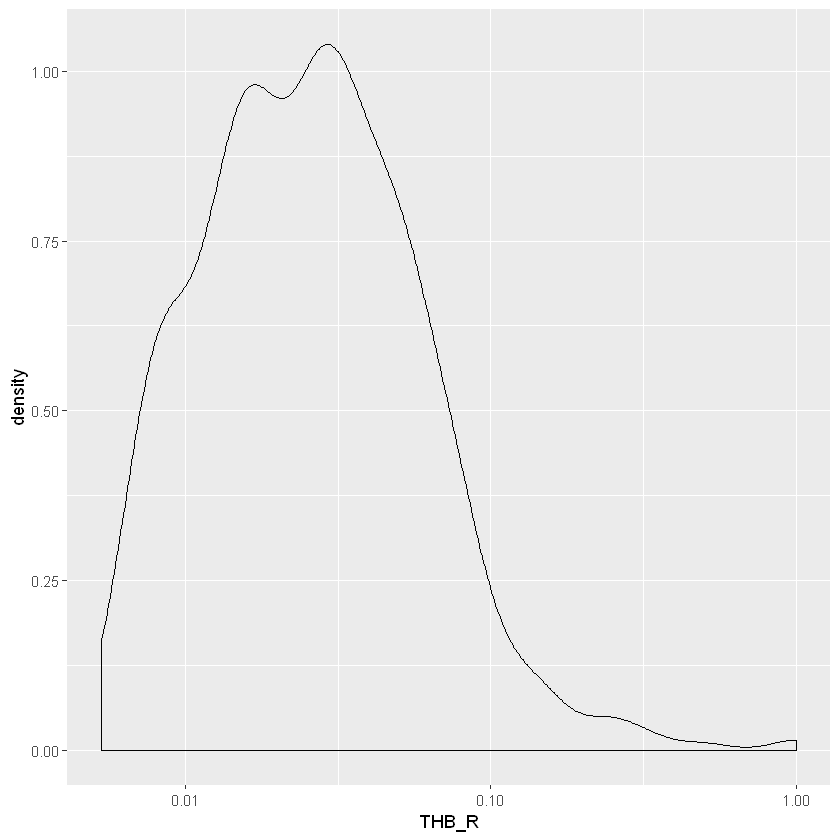

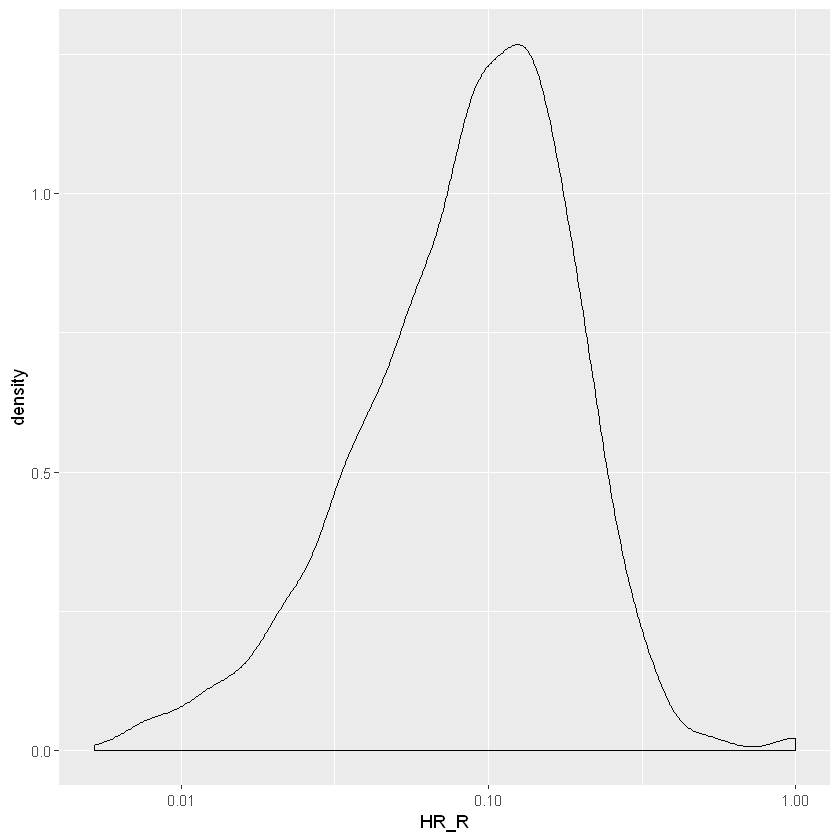

In [36]:
log_density_plot <- function(){
  for(i in new_col){
    print(ggplot(data = rsb_r, aes_string(i)) + geom_density(stat = 'density') + xlab(i) + scale_x_continuous(trans='log10'))
  }
}

log_density_plot()

In [42]:
colnames(rsb_r)

[1] "batter_id"   "batter_name" "year"        "avg"         "G"          
 [6] "AB"          "R"           "H"           "ONB"         "TWB"        
[11] "THB"         "HR"          "RBI"         "SB"          "CS"         
[16] "BB"          "HBP"         "SO"          "GDP"         "ONB_R"      
[21] "TWB_R"       "THB_R"       "HR_R"        "submem"

In [43]:
rsb_re <- rsb_r %>% select(batter_id:H, ONB_R, TWB_R, THB_R, HR_R, submem, RBI:GDP)

In [44]:
dbd_tmp = fread('data/Regular_Season_Batter_Day_by_Day.csv', encoding = 'UTF-8') %>% as.tibble

#### 전반기, 후반기 나누기.
dbd = dbd_tmp %>%
  mutate(`1B` = H - `2B` - `3B` - `HR`) %>%
  select(batter_id, batter_name, year, date, opposing_team, avg1, AB, R, H, `1B`, everything())

criterion = 7.17 # 전반기, 후반기 기준 날짜.

dbd_fh = dbd %>% filter(date <= criterion) # 전반기 데이터

#### 전반기 OPS 계산하기
rsb_fh_y = dbd_fh %>% group_by(batter_id, batter_name, year) %>%
  summarise(OBP = (sum(H) + sum(BB) + sum(HBP))/(sum(AB) + sum(BB) + sum(HBP)), SLG = (sum(`1B`) + sum(`2B`)*2 + sum(`3B`)*3 + sum(HR)*4)/sum(AB), AB = sum(AB)) %>%
  mutate(OPS = OBP + SLG) %>% ungroup()


In [50]:
#### Lag 3 데이터 만들기.

rsb_re_lag3 <- rsb_re %>%
  group_by(batter_id, batter_name) %>%
  mutate_at(vars('avg':'GDP'), funs(lag1 = lag(., 1), lag2 = lag(., 2), lag3 = lag(., 3))) %>% 
  ungroup()

rsb_re_lag3 <- rsb_re_lag3 %>%
  mutate(t_year = year + 1) # year + 1 로 타겟이 되는 연도 변수 생성

rsb_fh_OPS <- rsb_fh_y %>% select(-OBP, -SLG)

colnames(rsb_fh_OPS) <- c('batter_id', 'batter_name', 'year', 't_AB', 't_OPS')

dataset <- rsb_re_lag3 %>% inner_join(rsb_fh_OPS, by = c('batter_id', 'batter_name', 't_year' = 'year')) # 타겟 변수인 OPS, AB 붙이기

dataset <- dataset %>% select(-batter_name, -year, -t_year)

dataset <- apply(dataset, 2, function(x) ifelse(is.nan(x)|is.na(x), 0, x)) %>% as.tibble() # NA를 0으로 대체.

dataset <- dataset %>% mutate(inx = row_number())

#### Stratified Sampling Method 

#### submem에 따라 고정된 비율로 sampling

set.seed(526)

lag3_train_data <- dataset %>% 
  group_by(submem) %>% 
  sample_frac(0.7) %>% 
  ungroup()

train_inx <- lag3_train_data$inx

lag3_test_data <- dataset[-train_inx,]

lag3_train_data <- lag3_train_data %>% select(-inx)

lag3_test_data <- lag3_test_data %>% select(-inx)

save(lag3_train_data, lag3_test_data, file = 'lag3_data.Rdata')

In [55]:
#### Lag 5 데이터 만들기.

rsb_re_lag5 <- rsb_re %>%
  group_by(batter_id, batter_name) %>%
  mutate_at(vars('avg':'GDP'), funs(lag1 = lag(., 1), lag2 = lag(., 2), lag3 = lag(., 3), lag4 = lag(., 4), lag5 = lag(., 5))) %>% 
  ungroup()

rsb_re_lag5 <- rsb_re_lag5 %>%
  mutate(t_year = year + 1) # year + 1 로 타겟이 되는 연도 변수 생성

dataset2 <- rsb_re_lag5 %>% inner_join(rsb_fh_OPS, by = c('batter_id', 'batter_name', 't_year' = 'year')) # 타겟 변수인 OPS, AB 붙이기

dataset2 <- dataset2 %>% select(-batter_name, -year, -t_year)

dataset2 <- apply(dataset2, 2, function(x) ifelse(is.nan(x)|is.na(x), 0, x)) %>% as.tibble() # NA를 0으로 대체.

dataset2 <- dataset2 %>% mutate(inx = row_number())

#### Stratified Sampling Method 

#### submem에 따라 고정된 비율로 sampling

set.seed(1)

lag5_train_data <- dataset2 %>% 
  group_by(submem) %>% 
  sample_frac(0.7) %>% 
  ungroup()

train_inx <- lag5_train_data$inx

lag5_test_data <- dataset2[-train_inx,]

lag5_train_data <- lag5_train_data %>% select(-inx)

lag5_test_data <- lag5_test_data %>% select(-inx)

save(lag5_train_data, lag5_test_data, file = 'lag5_data.Rdata')

### Case2. 1~3루타, 홈런을 타수로 나눔.

In [56]:
rsb_div_AB <- rsb %>% mutate_at(vars('ONB':'HR'), funs(R = ./AB))

rsb_div_AB <- rsb_div_AB %>% mutate(submem = if_else(AB < 10, 1, 0))

rsb_div_AB <- rsb_div_AB %>% select(batter_id:H, ONB_R, TWB_R, THB_R, HR_R, submem, RBI:GDP)

#### Lag 5 데이터 만들기.

rsb_div_AB_lag5 <- rsb_div_AB %>%
  group_by(batter_id, batter_name) %>%
  mutate_at(vars('avg':'GDP'), funs(lag1 = lag(., 1), lag2 = lag(., 2), lag3 = lag(., 3), lag4 = lag(., 4), lag5 = lag(., 5))) %>% 
  ungroup()

rsb_div_AB_lag5 <- rsb_div_AB_lag5 %>%
  mutate(t_year = year + 1) # year + 1 로 타겟이 되는 연도 변수 생성

dataset3 <- rsb_div_AB_lag5 %>% inner_join(rsb_fh_OPS, by = c('batter_id', 'batter_name', 't_year' = 'year')) # 타겟 변수인 OPS, AB 붙이기

dataset3 <- dataset3 %>% select(-batter_name, -year, -t_year)

dataset3 <- apply(dataset3, 2, function(x) ifelse(is.nan(x)|is.na(x), 0, x)) %>% as.tibble() # NA를 0으로 대체.

dataset3 <- dataset3 %>% mutate(inx = row_number())

#### Stratified Sampling Method 

#### submem에 따라 고정된 비율로 sampling

set.seed(1)

lag5_train_data <- dataset3 %>% 
  group_by(submem) %>% 
  sample_frac(0.7) %>% 
  ungroup()

train_inx <- lag5_train_data$inx

lag5_test_data <- dataset3[-train_inx,]

lag5_train_data <- lag5_train_data %>% select(-inx)

lag5_test_data <- lag5_test_data %>% select(-inx)

save(lag5_train_data, lag5_test_data, file = 'lag5_AB_data.Rdata')